# Tarea - Modelo ARIMA

Sofía Maldonado García 

11/02/2026

### 1) Utilizando como base la forma canónica de un modelo ARIMA (p,d,q) desarrollar el caso en el que se considera un modelo de orden ARIMA(2,1,2)
- Realizar el procedimiento y detalle de sus conclusiones/pasos.

Considerando la forma canónica:
$$
\phi_{p}(B)(1-B)^dY_{t}=c+\theta_{q}(B)\epsilon_{t}
$$
Donde:
$$
\phi_{p}(B)=1-\phi_{1}B-\phi_{2}B^2-\dots-\phi_{p}B^p 
$$
Y:
$$
\theta_{q}(B)= 1 + \theta_{1}B+\theta_{2}B^2+\dots+\theta_{q}B^q
$$
Un modelo ARIMA con orden (2,1,2) sería representado como:
$$
(1-\phi_{1}B-\phi_{2}B^2)(1-B)Y_{t}=c+(1+\theta_{1}B+\theta_{2}B^2)\epsilon_{t}
$$
Desarrollando...
$$
(1-\phi_{1}B-\phi_{2}B^2-B+\phi_{1}B^2+\phi_{2}B^3)Y_{t}=c+(1+\theta_{1}B+\theta_{2}B^2)\epsilon_{t}
$$
Simplificando...
$$
(1-(1+\phi_{1})B+(\phi_{1}-\phi_{2})B^2+\phi_{2}B^3)Y_{t}=c+(1+\theta_{1}B+\theta_{2}B^2)\epsilon_{t}
$$
Considerando $B^kY_{t}=Y_{t-k}\dots$
$$
Y_{t}-(1+\phi_{1})Y_{t-1}+(\phi_{1}-\phi_{2})Y_{t-2}+\phi_{2}Y_{t-3} = c+\epsilon_{t}+\theta_{1}\epsilon_{t-1}+\theta_{2}\epsilon_{t-2} 
$$
Pasando todo a la derecha excepto $Y_{t}\dots$
$$
Y_{t}=c+\epsilon_{t}+\theta_{1}\epsilon_{t-1}+\theta_{2}\epsilon_{t-2}+(1+\phi_{1})Y_{t-1}-(\phi_{1}-\phi_{2})Y_{t-2}-\phi_{2}Y_{t-3}
$$
$\square$

### 2) Realizar un modelo para pronóstico de una serie de tiempo (el estudiante decide qué datos usar) utilizando 3 librerías de forecast en Python.
- Validar si su modelo se realiza con una serie de tiempo estacionaria o no
- Graficar serie de tiempo utilizando la librería plotly
- Comprobar los resultados obtenidos en las diferentes librerías

In [47]:
# Imports
# Generales
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

# Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss

***Loading Data***

Los datos utilzados son estadísticas oficiales de la Oficina del Censo de Estados Unidos. Estos datos son el gasto total en construcción en todo el país entre enero del 2011 y diciembre del 2024

In [35]:
df = pd.read_csv("data/us_construction_2011_2024.csv")
df.index.name = "Period"
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Period  168 non-null    str  
 1   Value   168 non-null    int64
dtypes: int64(1), str(1)
memory usage: 2.8 KB


In [36]:
msk = (df.index < len(df)-24)
df_train = df[msk].copy()
df_test = df[~msk].copy()

In [37]:
fig = px.line(df, x='Period', y='Value')
fig.show()

Hay mucha estacionalidad en los datos, ya que siempre bajan en los últimos meses del año y suben durante el siguiente.

Ahora, revisando si es estacionaria o no

In [38]:
val_dickey_fuller = adfuller(df['Value'])
kpss_test = kpss(df['Value'])
print(f"Dickey-Fuller: {val_dickey_fuller[1]}")
print(f"KPSS: {kpss_test[1]}")

Dickey-Fuller: 0.9877708400516507
KPSS: 0.01


/tmp/ipykernel_7019/832889593.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




En base a estas pruebas, se puede decir que la serie de tiempo **no es estacionaria**.

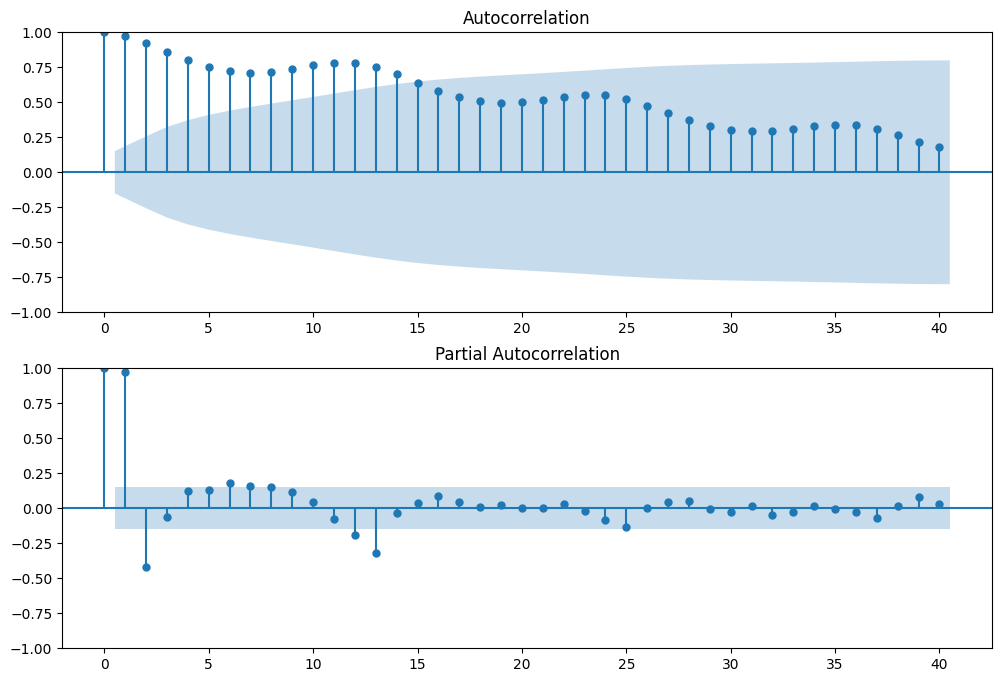

In [39]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Value'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Value'], lags=40, ax=ax2)

Checando si con una diferenciación ya es estacionaria...

In [40]:
df['diff_1'] = df['Value'].diff()

In [41]:
val_dickey_fuller = adfuller(df['diff_1'].dropna())
kpss_test = kpss(df['diff_1'].dropna())
print(f"Dickey-Fuller: {val_dickey_fuller[1]}")
print(f"KPSS: {kpss_test[1]}")

Dickey-Fuller: 0.02236230917339087
KPSS: 0.1


/tmp/ipykernel_7019/644339578.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Ya lo es!

En base a estas gráficas, parece que una configuración (2,1,2) podría ser un buen baseline.

In [42]:
arima_baseline_sm = ARIMA(df['Value'], order=(2,1,2)).fit()
print(arima_baseline_sm.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  168
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1636.190
Date:                Tue, 10 Feb 2026   AIC                           3282.379
Time:                        14:41:41   BIC                           3297.969
Sample:                             0   HQIC                          3288.707
                                - 168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7273      0.013    128.482      0.000       1.701       1.754
ar.L2         -0.9919      0.015    -67.389      0.000      -1.021      -0.963
ma.L1         -1.6933      0.046    -36.837      0.0

Checando los residuales...

In [43]:
residuales = arima_baseline_sm.resid[1:]
fig = px.line(residuales, y=residuales)
fig.show()

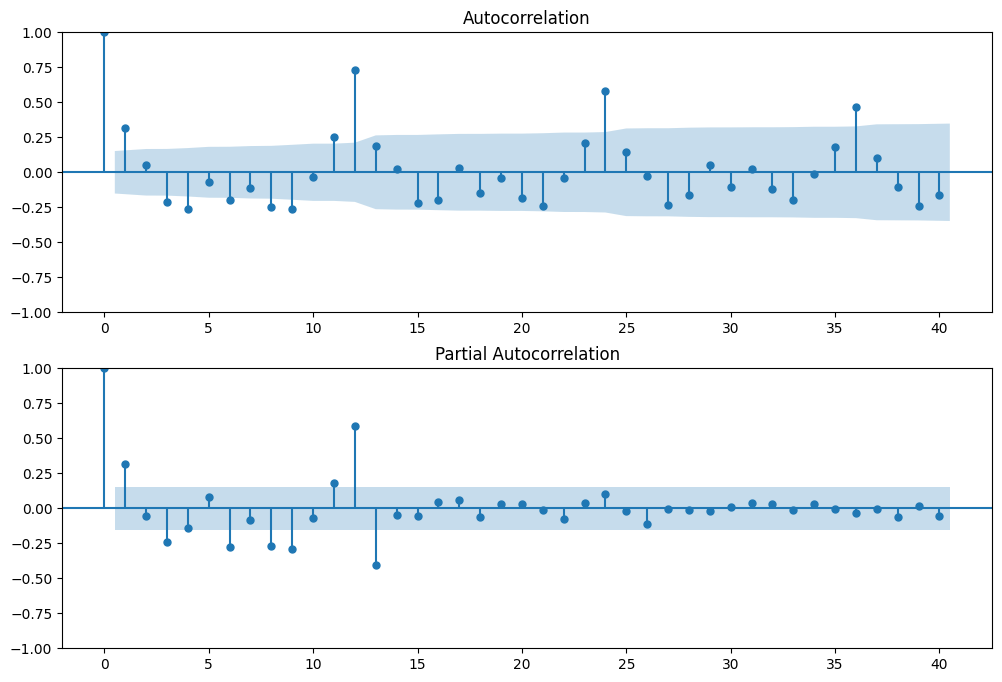

In [44]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuales, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuales, lags=40, ax=ax2)

Prediciendo...

<Axes: xlabel='Period'>

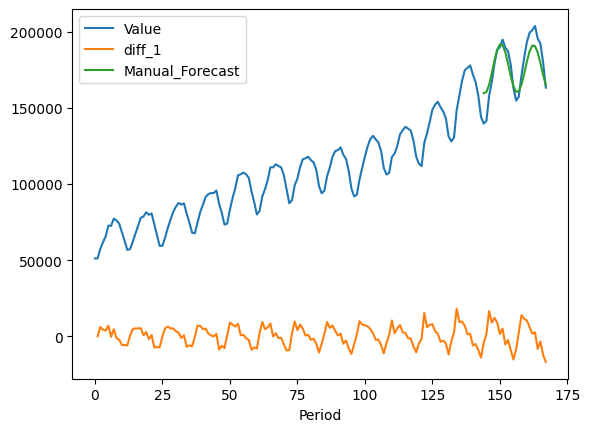

In [45]:
preds_sm = arima_baseline_sm.forecast(len(df_test)) # Es decir, para 2023 y 2024

df['Manual_Forecast'] = [None]*len(df_train) + list(preds_sm)

df.plot()